## AlexNet, ResNet, and VGGNet for Alzheimer's Disease Classification

In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [2]:
# check if GPU is available for use, if so, print the name of it
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
cuda:0
1
NVIDIA GeForce RTX 3060


In [3]:
# if GPU is available, set it to curr_device
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
    
curr_device = torch.device(dev)

(227, 227)


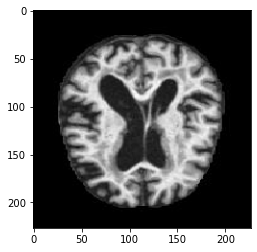

In [4]:
imgPath = "G:/My Drive/Kaggle/train/mildDem613.jpg"
img = load_img(imgPath, target_size = (227, 227))
print(img.size)
plt.imshow(img); plt.show()

## Classifying MRI Data

In [5]:
# Create training and testing datasets from folders of images

# Establish transformations for each dataset
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(
#     (0.5,), (0.5))
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# training dataset
path = "G:/My Drive/Kaggle/train/"
img_size = 227
train_img = []
train_labels = []
for imgFile in os.listdir(path):
    # create list of labels
    if imgFile.startswith('non'):
        train_labels.append(0)
    elif imgFile.startswith('verymild'):
        train_labels.append(1)
    elif imgFile.startswith('mildDem'):
        train_labels.append(2)
    elif imgFile.startswith('moderate'):
        train_labels.append(3)
    # resize images and append to a list
    imgPath = path+imgFile
    img = load_img(imgPath, target_size = (img_size, img_size))
    img = train_transforms(img)
    train_img.append(img)

# test dataset    
path = "G:/My Drive/Kaggle/test/"
test_img = []
test_labels = []
for imgFile in os.listdir(path):
    # create list of labels
    if imgFile.startswith('non'):
        test_labels.append(0)
    elif imgFile.startswith('veryMild'):
        test_labels.append(1)
    elif imgFile.startswith('mildDem'):
        test_labels.append(2)
    elif imgFile.startswith('moderate'):
        test_labels.append(3)
    # resize images and append to a list
    imgPath = path+imgFile
    img = load_img(imgPath, target_size = (img_size, img_size))
    img = test_transforms(img)
    test_img.append(img)

In [6]:
# append train_img and test_img to create a larger pool to sample from
total_img = train_img + test_img
total_labels = train_labels + test_labels
print(len(total_img))
print(len(total_labels))

6400
6400


In [7]:
X_train, X_val, y_train, y_val = train_test_split(total_img, total_labels, test_size=0.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=2)
print(len(X_train))
print(len(X_val))
print(len(X_test))

3840
1280
1280


In [8]:
# stack the list of tensors
train_img = torch.stack(X_train, dim = 0)
val_img = torch.stack(X_val, dim = 0)
test_img = torch.stack(X_test, dim = 0)

# convert labels into tensors
tensor_labels = torch.Tensor(y_train)
tensor_labels2 = torch.Tensor(y_val)
tensor_labels3 = torch.Tensor(y_test)

In [9]:
# create datasets 
train = torch.utils.data.TensorDataset(train_img, tensor_labels)
val = torch.utils.data.TensorDataset(val_img, tensor_labels2)
test = torch.utils.data.TensorDataset(test_img, tensor_labels3)

# create data loaders for training and testing datasets
train_batch_size = 40
val_batch_size = 16
test_batch_size = 16
train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size,
                                          shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = val_batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size,
                                          shuffle = True)


In [10]:
train_features, tr_labels = next(iter(train_loader))
print(train_features.shape)
print(np.unique(train_labels))

torch.Size([40, 3, 227, 227])
[0 1 2 3]


In [11]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=1000, input_channels=3, p_drop=0.5):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super(AlexNet, self).__init__()
        
        # convolutional and max pooling layers
        self.net = nn.Sequential(
            # Input: (n x 227 x 227 x 3)
            # Convolutional layer 1 w/ max pooling
            # (n x 55 x 55 x 96)
            nn.Conv2d(in_channels=input_channels, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=96),
            
            # (n x 27 x 27 x 96)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Convolutional layer 2 w/ max pooling 
            # (n x 27 x 27 x 256)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256),
            
            # (n x 13 x 13 x 256)
            nn.MaxPool2d(kernel_size=3, stride=2) ,
            
            # Convolutional layer 3 
            # (n x 13 x 13 x 384)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=384),
            
            # Convolutional layer 4 
            # (n x 13 x 13 x 384)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=384),
            
            # Convolutional layer 5 
            # (n x 13 x 13 x 256)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256),
            
            
            # Max pooling layer 
            # (n x 6 x 6 x 256)
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # 3 fully connected layers
        self.classifier = nn.Sequential(
            # Input: (n x 9216)
            # Dropout layer 1
            nn.Dropout(p=p_drop),
            
            # Fully connected layer 1 
            # (n x 4096)
            nn.Linear(9216, 4096),
            nn.ReLU(),
            
            # Dropout layer 2
            nn.Dropout(p=p_drop),
            
            # Fully connected layer 2 
            # (n x 4096)
            nn.Linear(4096, 4096),
            nn.ReLU(),
            
            # Fully connected layer 3 
            # (n x num_classes)
            nn.Linear(4096, num_classes)
        )
       
        # initialize bias
        
        self.init_bias()

    def init_bias(self):
        # Initialize weights according to original paper
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # changed indices due to variability in layers 
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[11].bias, 1)
        nn.init.constant_(self.net[14].bias, 1)

    def forward(self, x):
        x = self.net(x)
        # reduce the dimensions for linear layer input
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        out = F.softmax(x, dim=1)
        return out

In [12]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)
    
class ResNet18(nn.Module):
    def __init__(self, input_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = input.reshape(input.size(0), -1)
        input = self.fc(input)
        input = F.softmax(input, dim=1)
        return input

In [13]:
class VGG16(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [15]:
# Set the seed value
# Ensure reproducibility for each run
seed = torch.initial_seed() % (2**32-1)
np.random.seed(seed)
torch.manual_seed(seed)

# create model 
model = AlexNet(num_classes=4, input_channels=3)
# model = ResNet18(input_channels=3, resblock=ResBlock, outputs=4)
# model = VGG16(input_channels=3, num_classes=4)

model.to(curr_device) # move the model to GPU

#Definition of hyperparameters
num_epochs = 20
learning_rate = 1.5e-5

# Define loss function
error = nn.CrossEntropyLoss()

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

reg_penalty = 1e-6
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
val_accuracy_list = []
best_acc = 0
for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0
    train_label_list = []
    train_pred_list = []
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        img_tr = (images.view(train_batch_size,3,img_size,img_size))
        img_tr = img_tr.to(curr_device)
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(curr_device)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(img_tr)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels.long())
        loss_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # formula for L2 regularization
        loss = loss + reg_penalty*loss_norm
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        count += 1
        running_loss += loss.data
        
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == labels).sum()
        total += len(labels)
        train_label_list.append(labels)
        train_pred_list.append(predicted)
    accuracy_list.append(correct/total)
    loss_list.append(running_loss/i+1)
    
    correct_val = 0
    total_val = 0
    val_label_list = []
    val_pred_list = []
    # Evaluate model on validation set
    for j, (v_images, v_labels) in enumerate(val_loader):
        model.eval()
        img_val = (v_images.view(val_batch_size,3,img_size,img_size))
        img_val = img_val.to(curr_device)
        v_labels = v_labels.type(torch.LongTensor)
        v_labels = v_labels.to(curr_device)
        pred_val = model(img_val)
        pred_val = torch.max(pred_val.data, 1)[1]
        correct_val += (pred_val == v_labels).sum()
        total_val += len(v_labels)
        val_label_list.append(v_labels)
        val_pred_list.append(pred_val)
    curr_acc = correct_val/total_val
    val_accuracy_list.append(curr_acc)
    
    if curr_acc > best_acc:
        torch.save(model, 'model.pth')
        ckpt = {'train_losses': loss_list, 'train_acc': accuracy_list, 'val_acc': val_accuracy_list, 'epochs': num_epochs, 'model_weights': model.state_dict(), 'optimizer_state': optimizer.state_dict()}
        torch.save(ckpt, 'model_losses.ckpt')           
        best_acc = float(curr_acc)

    # Print Loss
    print('Epoch: [{}/{}]  Loss: {}  Training Acc: {} % Validation Acc: {} %'.format(epoch+1, num_epochs, (running_loss/i+1), (correct/total)*100, curr_acc*100))

Epoch: [1/20]  Loss: 2.2068777084350586  Training Acc: 53.56771469116211 % Validation Acc: 57.8125 %
Epoch: [2/20]  Loss: 2.175234794616699  Training Acc: 56.718753814697266 % Validation Acc: 57.5 %
Epoch: [3/20]  Loss: 2.1582517623901367  Training Acc: 59.270835876464844 % Validation Acc: 57.187503814697266 %
Epoch: [4/20]  Loss: 2.1324470043182373  Training Acc: 61.66666793823242 % Validation Acc: 57.734375 %
Epoch: [5/20]  Loss: 2.0923328399658203  Training Acc: 66.04167175292969 % Validation Acc: 65.625 %
Epoch: [6/20]  Loss: 2.0598466396331787  Training Acc: 69.60938262939453 % Validation Acc: 53.046875 %
Epoch: [7/20]  Loss: 2.0139613151550293  Training Acc: 74.66146087646484 % Validation Acc: 64.453125 %
Epoch: [8/20]  Loss: 1.990308403968811  Training Acc: 76.74479675292969 % Validation Acc: 71.015625 %
Epoch: [9/20]  Loss: 1.9663598537445068  Training Acc: 79.34896087646484 % Validation Acc: 75.703125 %
Epoch: [10/20]  Loss: 1.946637749671936  Training Acc: 81.38021087646484 %

In [16]:
# copy lists from GPU to CPU
loss_plot = torch.tensor(loss_list).cpu()
accuracy_plot = torch.tensor(accuracy_list).cpu()
val_accuracy_plot = torch.tensor(val_accuracy_list).cpu()

In [17]:
# convert labels and predictions to lists that can be fed to a confusion matrix
'''
var_tensor: the list of tensors (i.e. predictions/labels) to be converted to a numpy array
'''
def conv_tensor2list(var_tensor):
    var_list = []
    for i in range(len(var_tensor)):
        row = var_tensor[i].cpu().detach().numpy()
        for j in range(len(row)):
            var_list.append(row[j])
    return var_list

val_pred = conv_tensor2list(val_pred_list)
val_label = conv_tensor2list(val_label_list)

train_pred = conv_tensor2list(train_pred_list)
train_label = conv_tensor2list(train_label_list)

Model Accuracy:  0.83515625
Model Accuracy:  0.91171875


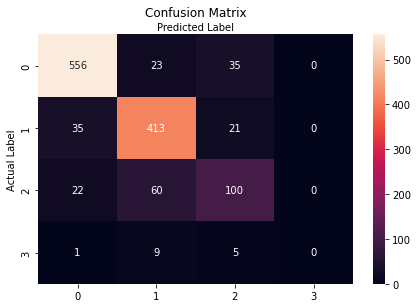

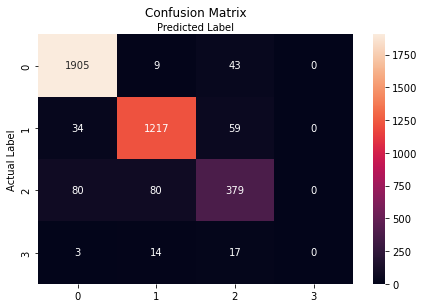

In [18]:
# visualize confusion matrix with a heatmap
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_mat(truth, pred):
    cnf_mat = metrics.confusion_matrix(truth, pred)

    class_names = [0, 1, 2, 3]
    fix, ax = plt.subplots()
    ticks = np.arange(len(class_names))
    plt.xticks (ticks, class_names)
    plt.yticks(ticks, class_names)

    # create the heatmap
    sns.heatmap(pd.DataFrame(cnf_mat), annot = True, fmt = 'g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")

    # print some of the statistics
    print("Model Accuracy: ", metrics.accuracy_score(truth, pred))


# see accuracy and confusion matrix  when using Gaussian NB
conf_mat(val_label, val_pred)
conf_mat(train_label, train_pred)

## Visualize metrics

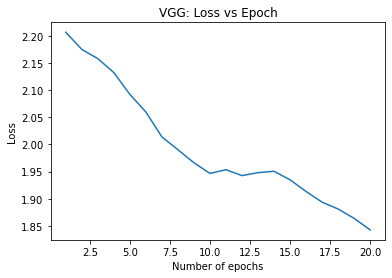

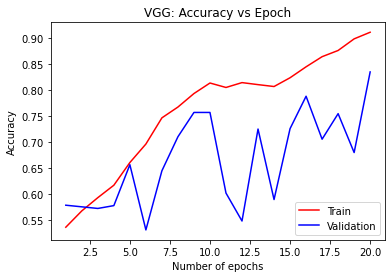

In [19]:
# visualization of loss 
epochs_list = np.arange(1, num_epochs+1)
plt.plot(epochs_list, loss_plot)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("VGG: Loss vs Epoch")
plt.show()

# visualization of training accuracy 
plt.plot(epochs_list, accuracy_plot, color = "red", label = 'Train')
plt.plot(epochs_list, val_accuracy_plot, color = "blue", label = 'Validation')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("VGG: Accuracy vs Epoch")
plt.legend(loc = "lower right")
plt.show()

## Use trained model on test set

Test Accuracy: 85.0 % 
Model Accuracy:  0.85


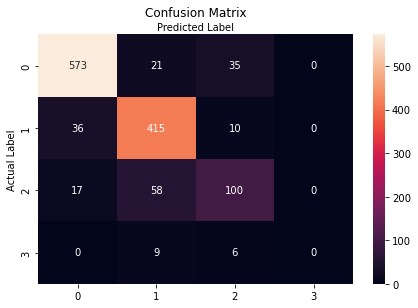

In [20]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
test_pred_list = []
test_label_list = []

correct = 0
total = 0
best_model = torch.load('model.pth') # Load the best performing model
for i, (images, labels) in enumerate(test_loader):
    best_model.eval()
    test = (images.view(test_batch_size,3,img_size,img_size))
    test = test.to(curr_device)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(curr_device)
    # make predictions
    outputs = best_model(test)
    predicted = torch.max(outputs.data, 1)[1]
    correct += (predicted == labels).sum()
    total += len(labels)
    accuracy_list.append(correct/total)
    test_pred_list.append(predicted)
    test_label_list.append(labels)

# Print test accuracy
print('Test Accuracy: {} % '.format((correct/total)*100))
test_pred = conv_tensor2list(test_pred_list)
test_label = conv_tensor2list(test_label_list)
conf_mat(test_label, test_pred)

C:\Users\hanbi\AppData\Local\Temp/ipykernel_23164/752453618.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pic = torch.tensor(pic).cpu()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

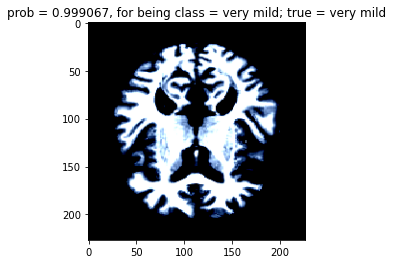

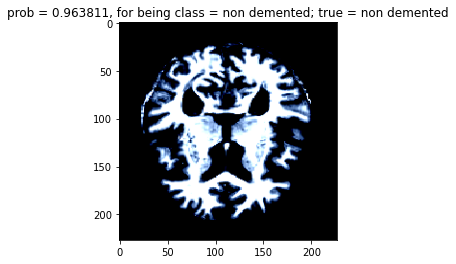

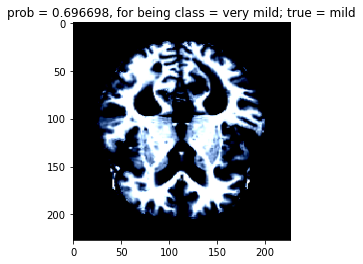

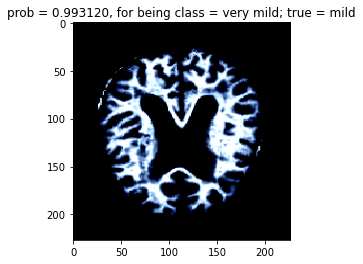

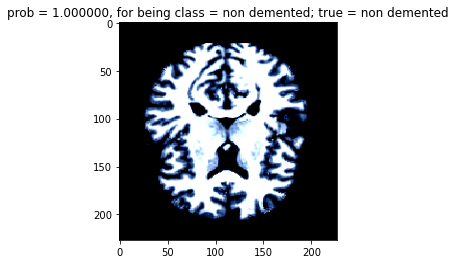

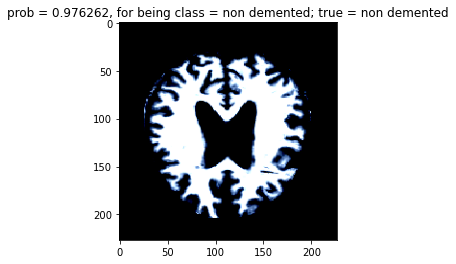

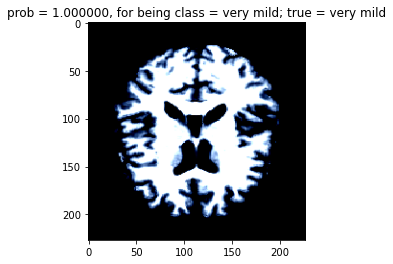

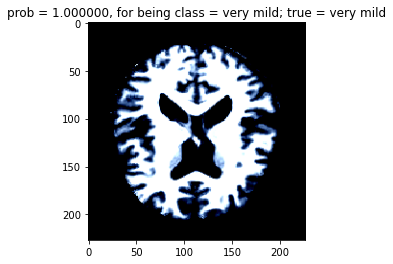

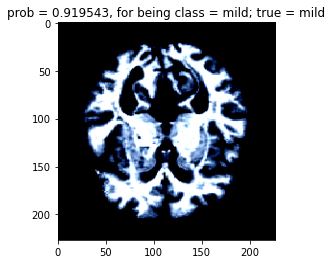

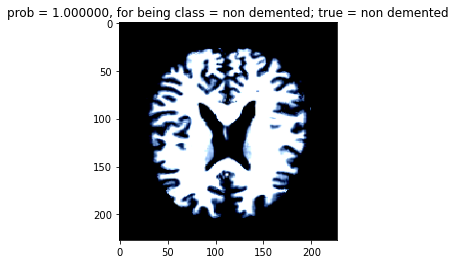

In [21]:
# load the first batch of test_loader
test_features, test_labels = next(iter(test_loader))
test_features = test_features.to(curr_device)
# Use the model to get the data's predicted classes and probabilities
outputs = model(test_features)

# Get predictions from the maximum value
predicted = torch.max(outputs.data, 1)[1]

# plot the first 10 test images
# have the title contain the probability of the predicted class
for i in range(10):
    pic = test_features[i]
    pic = torch.tensor(pic).cpu()
    pic = pic.permute(1, 2, 0)
    plt.figure()
    plt.imshow(pic)
    probs = outputs[i]
    class_val = predicted[i]
    prob = probs[class_val]
    true_val = test_labels[i]
    # from values, translate predicted class
    if class_val.item() == 0:
        class_result = 'non demented'
    elif class_val.item() == 1:
        class_result = 'very mild'
    elif class_val.item() == 2:
        class_result = 'mild'
    elif class_val.item() == 3:
        class_result = 'moderate'
    # from labels, translate true class
    if true_val.item() == 0:
        true_result = 'non demented'
    elif true_val.item() == 1:
        true_result = 'very mild'
    elif true_val.item() == 2:
        true_result = 'mild'
    elif true_val.item() == 3:
        true_result = 'moderate'
    title = 'prob = %f, for being class = %s; true = %s'% (prob.item(), class_result, true_result)
    plt.title(title)